In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [3]:
df = pd.read_csv(f'{DIR_INPUT}/train.csv')
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [4]:
df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x : np.fromstring(x[1:-1], sep=',', dtype=float)))
df.drop(columns=['bbox'], inplace=True)
df.head(3)

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0

In [5]:
df.shape

(147793, 8)

In [6]:
df['image_id'].nunique()

3373

In [7]:
len(os.listdir(DIR_TRAIN))

3422

上面我们可以看到我们存在一些照片是没有bbox的，也就是我们如果准备采用监督学习的话，我们只能使用`3373`个样本

In [8]:
image_ids = df['image_id'].unique()
train_size = 0.8
split_len = round(len(image_ids)*train_size)

train_ids = image_ids[:split_len]
valid_ids = image_ids[split_len:]

train = df[df['image_id'].isin(train_ids)]
valid = df[df['image_id'].isin(valid_ids)]
train.shape, valid.shape

((122577, 8), (25216, 8))

In [9]:
df['width'].unique(), df['height'].unique()

(array([1024]), array([1024]))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


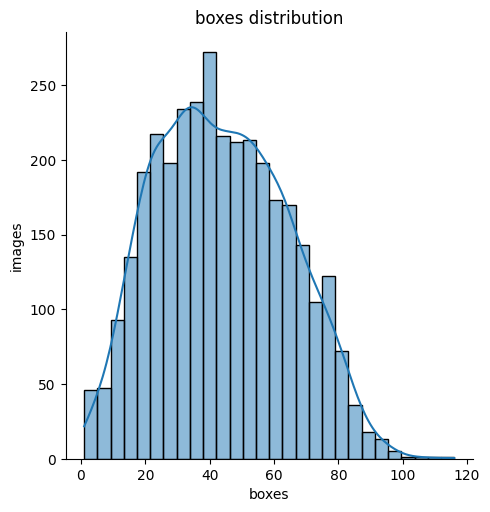

In [10]:
counts = df['image_id'].value_counts()
sns.displot(counts, kde=True)
plt.xlabel('boxes')
plt.ylabel('images')
plt.title('boxes distribution')
plt.show()

In [11]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(
      xy=(bbox[0], bbox[1]),
      width=bbox[2] - bbox[0],
      height=bbox[3] - bbox[1],
      fill=False,
      edgecolor=color,
      linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

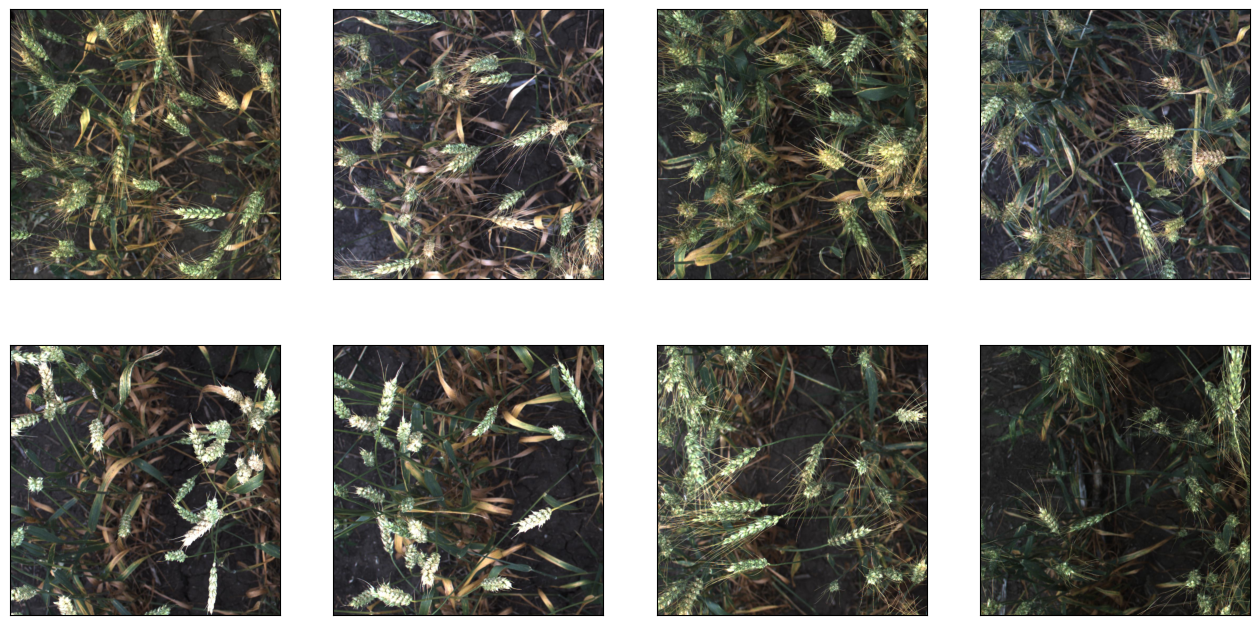

<Figure size 640x480 with 0 Axes>

In [12]:
num_rows, num_cols = 2, 4
imgs = [plt.imread(f'{DIR_TRAIN}/{n}.jpg') for n in df['image_id'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()
plt.tight_layout()

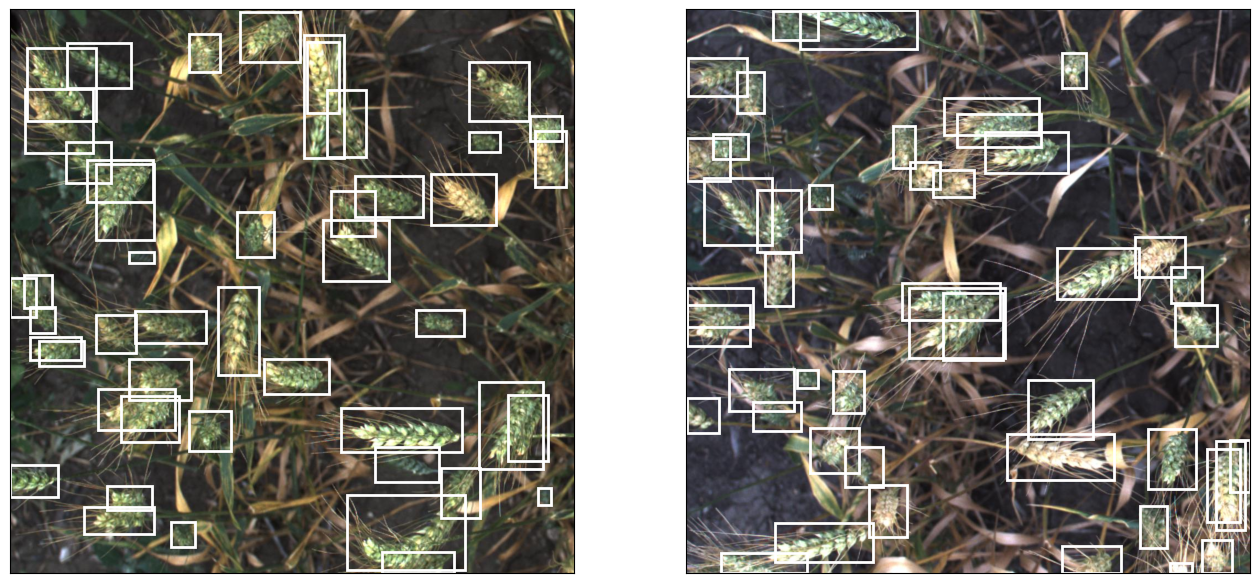

In [13]:
num_rows, num_cols = 1, 2
ids = df['image_id'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{DIR_TRAIN}/{n}.jpg') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = df[df['image_id'] == id]
  bboxes = [(d['x'], d['y'], d['x']+d['w'], d['y']+d['h']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

# 构建dataset

In [14]:
import cv2 as cv
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader

In [15]:
class Wheat(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x', 'y', 'w', 'h']].values
        
        area = boxes[:, 2] * boxes[:, 3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels,
            }
            sample = self.transforms(**sample)
            image = sample['image']
#             target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.tensor(sample['bboxes'])
#             print(target['boxes']==torch.tensor(sample['bboxes']))
        return image, target, image_id
        
    def __len__(self):
        return len(self.image_ids)
    
    @staticmethod
    def get_train_transform():
        return A.Compose([
            A.Flip(0.5),
            ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    @staticmethod
    def get_valid_transform():
        return A.Compose([
            ToTensorV2(p=0.1)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
        

In [16]:
train_dataset = Wheat(train, DIR_TRAIN, Wheat.get_train_transform())
valid_dataset = Wheat(valid, DIR_TRAIN, Wheat.get_valid_transform())

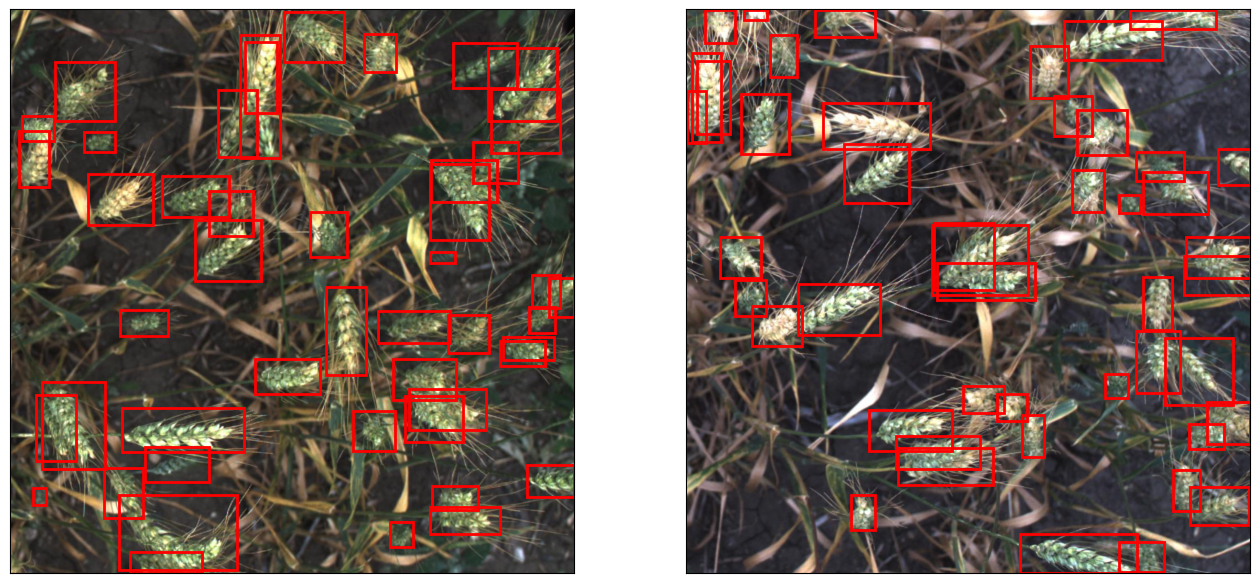

In [17]:
datas = [train_dataset[i] for i in range(2)]
imgs = [d[0].permute(1, 2, 0).numpy() for d in datas]
axes = show_images(imgs, 1, 2, scale=8)
for ax, (image, target, image_id) in zip(axes, datas):
    show_bboxes(ax, target['boxes'], labels=None, colors=['r'])
plt.show()

# 模型准备

In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [19]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 157MB/s]


In [20]:
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)


In [21]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [22]:
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.005)
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None
num_epochs = 10

# 模型训练

In [25]:
import time
from tqdm.notebook import tqdm as tqdm

itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0

for epoch in range(num_epochs):

  start_time = time.time()

  model.train()
  train_loss = []
  
  pbar = tqdm(train_data_loader, desc='let\'s train')
  for images, targets, image_ids in pbar:
    
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()


  with torch.no_grad():
    valid_loss = []

    for images, targets, image_ids in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)
        
  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)    
  

  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 1/10, Time: 360.50461506843567, Train Loss: 0.907226477523279, Valid Loss: 0.9159833917404258


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 2/10, Time: 343.72830390930176, Train Loss: 0.8165222995506385, Valid Loss: 0.8592314455537227


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 3/10, Time: 342.20594239234924, Train Loss: 0.7931852692514394, Valid Loss: 0.8300533119355584


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 4/10, Time: 341.98603081703186, Train Loss: 0.7771628456077926, Valid Loss: 0.8243426151412023


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 5/10, Time: 343.31982588768005, Train Loss: 0.7635280833875977, Valid Loss: 0.83528338491598


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 6/10, Time: 343.64016366004944, Train Loss: 0.7570041340818967, Valid Loss: 0.8277505392243258


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 7/10, Time: 342.9673547744751, Train Loss: 0.7470613032403366, Valid Loss: 0.8157153886564608


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 8/10, Time: 343.1612243652344, Train Loss: 0.7386308777503986, Valid Loss: 0.8193182671585061


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 9/10, Time: 342.5884165763855, Train Loss: 0.7326648625318769, Valid Loss: 0.8087250704296093


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 10/10, Time: 342.8344678878784, Train Loss: 0.7271029718230041, Valid Loss: 0.8103140808529126


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

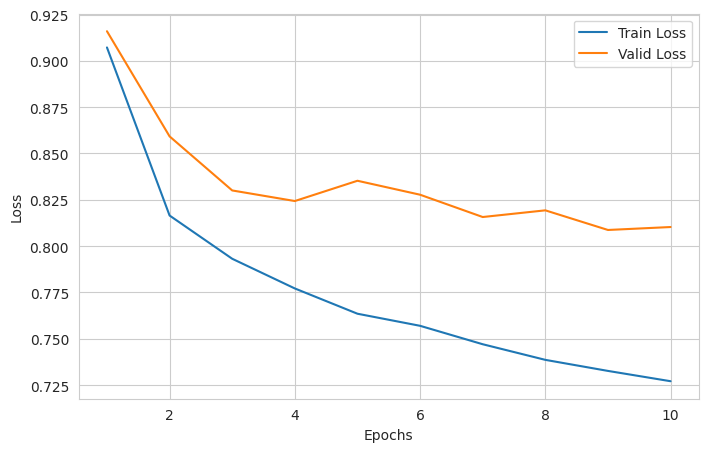

In [26]:
plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [27]:
torch.save(model, 'fasterrcnn_resnet50_fpn.pth')